<img src="images/Project Banner.png" style="max-width:100%; height:auto;">


## Handwritten Digit Recognition Using the MNIST Dataset

### 1.Business Understanding

Project Objective :

This project aims to design and evaluate a supervised machine learning model for handwritten digit recognition using the MNIST dataset. The task is formulated as a multi-class classification problem, where the input consists of 28×28 grayscale images and the output is a digit label from 0 to 9. Model performance is primarily assessed based on classification accuracy on the test set while minimizing overfitting.

### 2.Data Understanding

Dataset Description
The MNIST dataset consists of grayscale handwritten digit images with a resolution of 28×28 pixels, comprising 60,000 training samples and 10,000 test samples.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
import os, random
from tensorflow import keras
from keras.datasets import mnist
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")


In [3]:
# Reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [4]:
#Loading MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [5]:
print("Train:", train_images.shape, train_labels.shape)
print("Test :", test_images.shape,  test_labels.shape)
print("Pixel range:", train_images.min(), "to", train_images.max())

Train: (60000, 28, 28) (60000,)
Test : (10000, 28, 28) (10000,)
Pixel range: 0 to 255


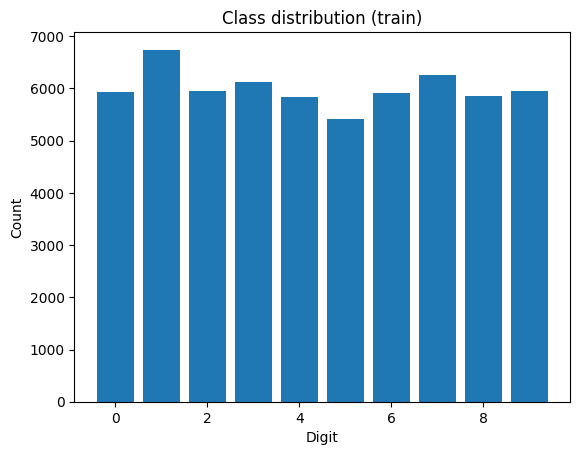

In [6]:
#Class distribution
unique, counts = np.unique(train_labels, return_counts=True)
plt.figure()
plt.bar(unique, counts)
plt.title("Class distribution (train)")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()


The MNIST dataset is approximately balanced, but not perfectly equal

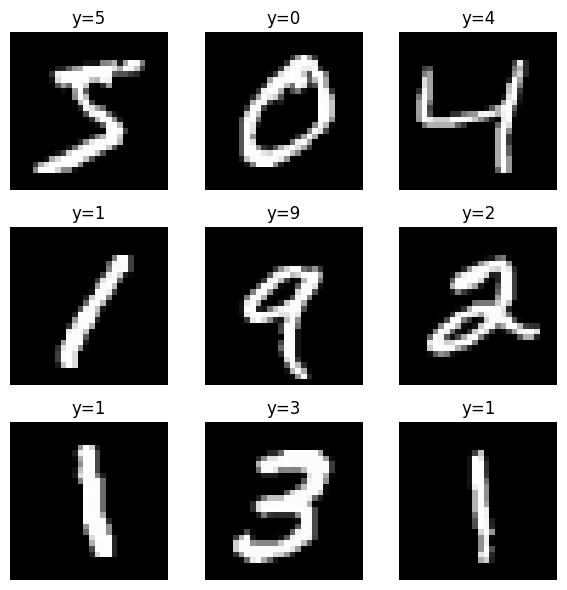

In [7]:
#Display sample images
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_images[i], cmap="gray")
    plt.title(f"y={train_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


### 3.Data Preparation

In [8]:
#Normalization and data type conversion
train_images_f  = train_images.astype("float32") / 255.0
test_images_f   = test_images.astype("float32") / 255.0

# Add channel dim: (N, 28, 28, 1)
train_images_f = train_images_f [..., np.newaxis]
test_images_f  = test_images_f [..., np.newaxis]

print(train_images_f .shape, test_images_f.shape)
 

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [9]:
#One-hot encode labels
train_labels_oh = to_categorical(train_labels, 10)
test_labels_oh  = to_categorical(test_labels, 10)

In [10]:
#Split validation set

X_tr, X_val, y_tr, y_val = train_test_split(
    train_images_f, train_labels_oh, test_size=0.1, random_state=SEED, stratify=train_labels
)

print("Train split:", X_tr.shape, y_tr.shape)
print("Val split  :", X_val.shape, y_val.shape)


Train split: (54000, 28, 28, 1) (54000, 10)
Val split  : (6000, 28, 28, 1) (6000, 10)


### 4.Modeling

In [11]:
#Baseline: Logistic Regression
train_images_flat = (train_images.astype("float32")/255.0).reshape(len(train_images), -1)
test_images_flat  = (test_images.astype("float32")/255.0).reshape(len(test_images), -1)


lr = LogisticRegression(max_iter=200, n_jobs=-1)
lr.fit(train_images_flat[:20000], train_labels[:20000])

pred_lr = lr.predict(test_images_flat)
print("Baseline LR Accuracy:", accuracy_score(test_labels, pred_lr))


Baseline LR Accuracy: 0.9165


In [12]:
#Main model: CNN
def build_cnn(input_shape=(28,28,1), num_classes=10):
    inp = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, padding="same")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out)


model = build_cnn()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,370 (435.04 KB)

 Trainable params: 110,922 (433.29 KB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=4, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5
    )
]

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 75s 170ms/step - accuracy: 0.8564 - loss: 0.4692 - val_accuracy: 0.3957 - val_loss: 2.0684 - learning_rate: 0.0010
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 81s 191ms/step - accuracy: 0.9608 - loss: 0.1324 - val_accuracy: 0.7657 - val_loss: 0.7102 - learning_rate: 0.0010
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 76s 181ms/step - accuracy: 0.9706 - loss: 0.0994 - val_accuracy: 0.9578 - val_loss: 0.1355 - learning_rate: 0.0010
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 78s 186ms/step - accuracy: 0.9749 - loss: 0.0835 - val_accuracy: 0.8437 - val_loss: 0.5190 - learning_rate: 0.0010
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 73s 172ms/step - accuracy: 0.9789 - loss: 0.0686 - val_accuracy: 0.9660 - val_loss: 0.1200 - learning_rate: 0.0010
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 79s 187ms/step - accuracy: 0.9810 - loss: 0.0616 - val_accuracy: 0.6637 - val_loss: 1.2863 - learning_rate: 0.0010
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 74s 176ms/step - accuracy: 0.9

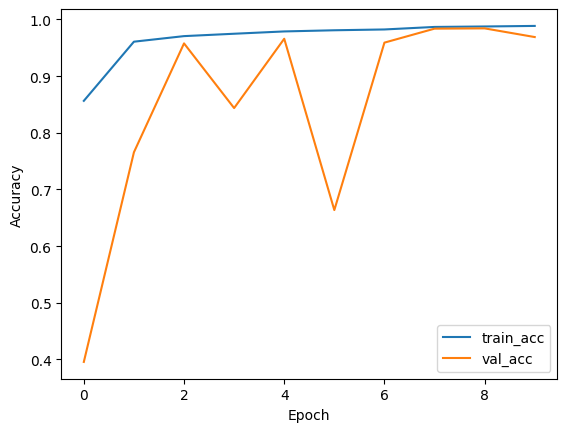

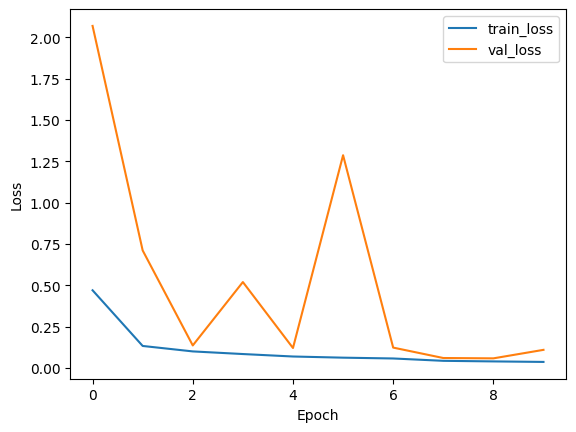

In [14]:
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


### 5.Evaluation

In [15]:
test_loss, test_acc = model.evaluate(test_images_f, test_labels_oh, verbose=0)
print("Test Accuracy:", test_acc)


Test Accuracy: 0.9866999983787537


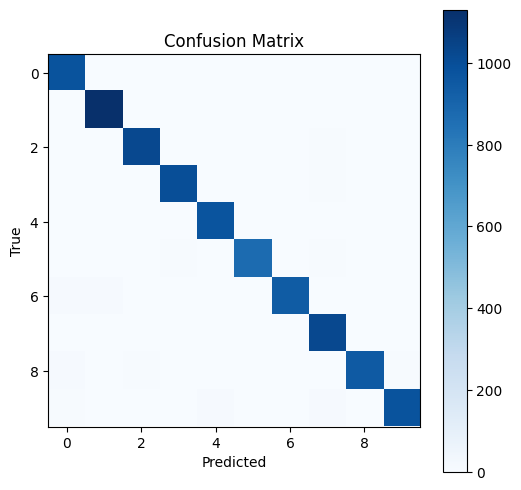

              precision    recall  f1-score   support

           0     0.9721    0.9969    0.9844       980
           1     0.9835    0.9965    0.9899      1135
           2     0.9865    0.9903    0.9884      1032
           3     0.9901    0.9891    0.9896      1010
           4     0.9839    0.9939    0.9889       982
           5     0.9966    0.9787    0.9876       892
           6     0.9968    0.9791    0.9879       958
           7     0.9715    0.9961    0.9837      1028
           8     0.9958    0.9743    0.9850       974
           9     0.9939    0.9693    0.9814      1009

    accuracy                         0.9867     10000
   macro avg     0.9871    0.9864    0.9867     10000
weighted avg     0.9869    0.9867    0.9867     10000



In [16]:
from sklearn.metrics import confusion_matrix, classification_report

y_prob = model.predict(test_images_f, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

cm = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(6,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

print(classification_report(test_labels, y_pred, digits=4))


Misclassified: 133


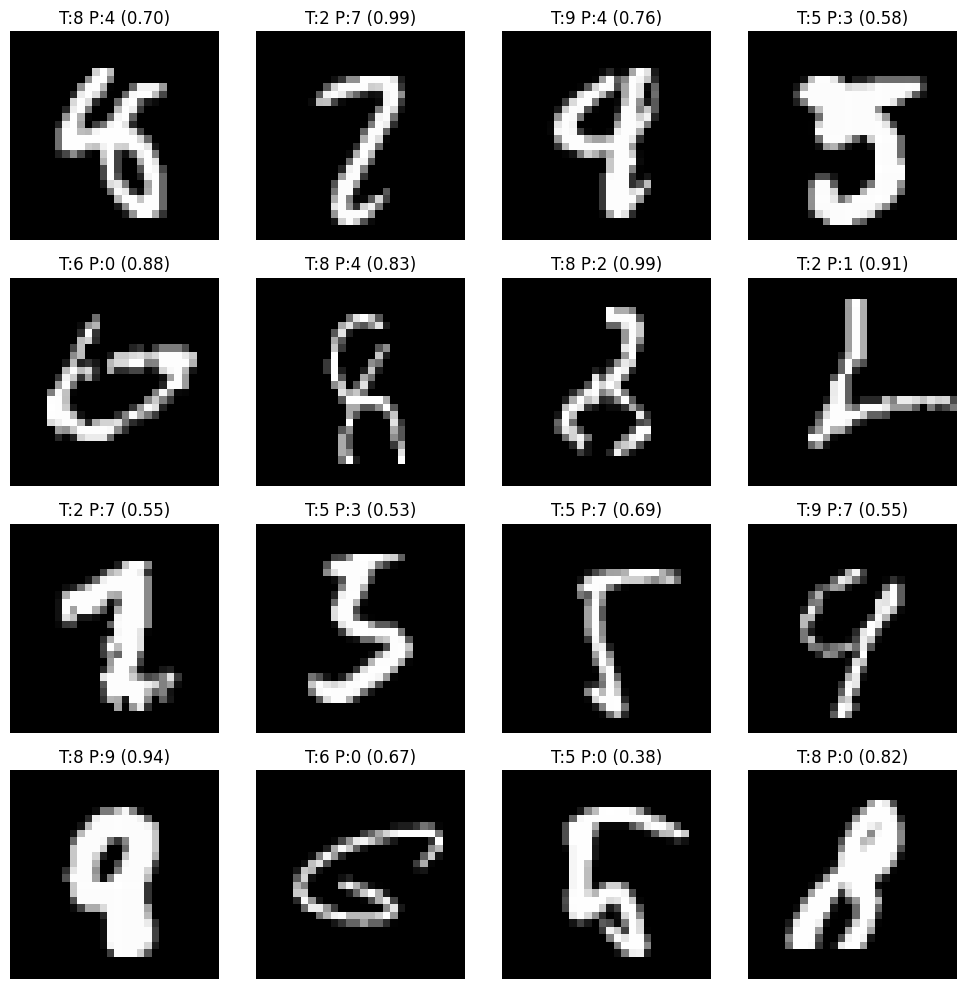

In [17]:
wrong = np.where(y_pred != test_labels)[0]
print("Misclassified:", len(wrong))

plt.figure(figsize=(10,10))
for i, idx in enumerate(wrong[:16]):
    plt.subplot(4,4,i+1)
    plt.imshow(test_images[idx], cmap="gray")
    plt.title(f"T:{test_labels[idx]} P:{y_pred[idx]} ({y_prob[idx,y_pred[idx]]:.2f})")
    plt.axis("off")
plt.tight_layout()
plt.show()


Many of the errors stem from visually similar digits (such as 4/9, 3/5, and 7/1) or from extremely low-quality handwritin

### 6.Deployment